# Time Series Analysis

https://machinelearningmastery.com/how-to-model-human-activity-from-smartphone-data/

* Prepare a dataset on which you can run time series clustering; motif/anomaly discovery and classification.
* On the dataset created, compute classification with KNN based on Euclidean/Manhattan and DTW distances and compare the results.
* To perform the clustering you can choose among different distance functions and clustering algorithms. Remember that you can reduce the dimensionality through time series approximation. Analyze the clusters and highlight similarities and differences.
* Analyze the dataset for finding motifs and/or anomalies. Visualize and discuss them and their relationship with other features.
* Solve the classification task on the time series dataset(s) and evaluate each result. In particular, you should use shapelet-based classifiers and structural-based classifiers. Analyze the shapelets retrieved and discuss if there are any similarities/differences with motifs and/or shapelets

# 1. Prepare a dataset on which you can run time series clustering; motif/anomaly discovery and classification.

#### Importing libraries

In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas import read_csv
from numpy import dstack

#### Loading Data

In [2]:
# Load single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [3]:
# Load a list of files, such as x, y, z data for a given variable
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

In [4]:
# Load a dataset group, such as train or test
def load_dataset(group):
    filepath = group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(group + '/y_'+group+'.txt')
    return X, y

In [5]:
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [6]:
# Load all train
X_train, y_train = load_dataset('train')
print('timesteps:', len(X_train[0]))
print('input dimension:', len(X_train[0][0]))
print('len of X_train:', len(X_train))
n_classes = _count_classes(y_train)
print('n classes:', n_classes)

timesteps: 128
input dimension: 9
len of X_train: 7352
n classes: 6


In [7]:
# Load all test
X_test, y_test = load_dataset('test')
print('timesteps:', len(X_test[0]))
print('input dimension:', len(X_test[0][0]))
print('len of X_test:', len(X_test))
n_classes = _count_classes(y_test)
print('n classes:', n_classes)

timesteps: 128
input dimension: 9
len of X_test: 2947
n classes: 6


#### Plot time series data for one subject

In [8]:
sub_map = load_file('train/subject_train.txt')
train_subjects = np.unique(sub_map)
print(train_subjects)

[ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]


In [9]:
# get all data for one subject
def data_for_subject(X, y, sub_map, sub_id):
    # get row indexes for the subject id
    ix = [i for i in range(len(sub_map)) if sub_map[i]==sub_id]
    # return the selected samples
    return X[ix, :, :], y[ix]

In [10]:
# convert a series of windows to a 1D list
def to_series(windows):
    series = list()
    for window in windows:
        # remove the overlap from the window
        half = int(len(window) / 2) - 1
        for value in window[-half:]:
            series.append(value)
    return series

In [11]:
# plot the data for one subject
def plot_subject(X, y):
    plt.figure()
    # determine the total number of plots
    n, off = X.shape[2] + 1, 0
    # plot total acc
    for i in range(3):
        plt.subplot(n, 1, off+1)
        plt.plot(to_series(X[:, :, off]))
        plt.title('total acc '+str(i), y=0, loc='left')
        off += 1
    # plot body acc
    for i in range(3):
        plt.subplot(n, 1, off+1)
        plt.plot(to_series(X[:, :, off]))
        plt.title('body acc '+str(i), y=0, loc='left')
        off += 1
    # plot body gyro
    for i in range(3):
        plt.subplot(n, 1, off+1)
        plt.plot(to_series(X[:, :, off]))
        plt.title('body gyro '+str(i), y=0, loc='left')
        off += 1
    # plot activities
    plt.subplot(n, 1, n)
    plt.plot(y)
    plt.title('activity', y=0, loc='left')
    plt.show()

In [12]:
# get the data for one subject
sub_id = train_subjects[0]
X_sub, y_sub = data_for_subject(X_train, y_train, sub_map, sub_id)
print(X_sub.shape, y_sub.shape)

(347, 128, 9) (347, 1)


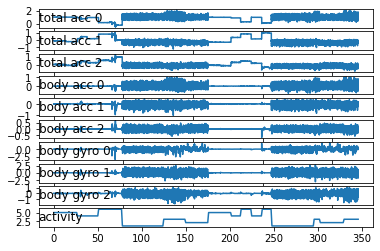

In [13]:
# plot data for subject
plot_subject(X_sub, y_sub)

#### Total acc x (Time series analysed)

The acceleration signal from the smartphone accelerometer X axis in standard gravity units 'g'. Every row shows a 128 element vector. 


In [14]:
X_train = X_train[:,:,0]
X_train.shape

(7352, 128)

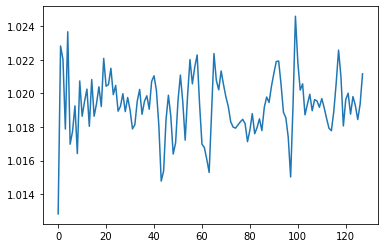

In [15]:
plt.plot(X_train[0])
plt.show()

In [16]:
X_test = X_test[:,:,0]
X_test.shape

(2947, 128)

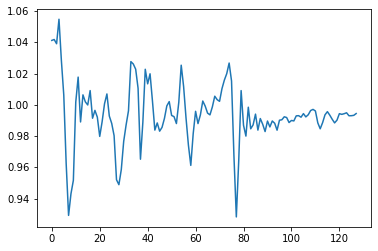

In [17]:
plt.plot(X_test[0])
plt.show()

# 2. On the dataset created, compute classification with KNN based on Euclidean/Manhattan and DTW distances and compare the results. 

In [18]:
import os
  
n_cpu = os.cpu_count()
print(n_cpu)

4


In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [20]:
# Knn euclidean distance 
clf_knn_ts = KNeighborsClassifier(n_neighbors=20, weights='distance')
clf_knn_ts.fit(X_train, y_train)

y_pred = clf_knn_ts.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

C:\Users\Cosimo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy 0.7034272141160502
F1-score [0.76707531 0.68893528 0.59766277 0.51731602 0.58479532 1.        ]
              precision    recall  f1-score   support

           1       0.68      0.88      0.77       496
           2       0.68      0.70      0.69       471
           3       1.00      0.43      0.60       420
           4       0.55      0.49      0.52       491
           5       0.53      0.66      0.58       532
           6       1.00      1.00      1.00       537

    accuracy                           0.70      2947
   macro avg       0.74      0.69      0.69      2947
weighted avg       0.73      0.70      0.70      2947



In [21]:
from pyts.classification import KNeighborsClassifier

In [21]:
# NON FARE IL RUN !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# Knn with DTW (takes PARECCHIO)
clf_knn_ts_dtw = KNeighborsClassifier(n_neighbors=20, weights='distance', metric='dtw', n_jobs=-1, leaf_size= 5)
clf_knn_ts_dtw.fit(X_train, y_train)

y_pred = clf_knn_ts_dtw.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

C:\Users\Cosimo\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy 0.7953851374278927
F1-score [0.91092746 0.78383838 0.78561151 0.59145674 0.67078553 1.        ]
              precision    recall  f1-score   support

           1       0.84      1.00      0.91       496
           2       0.75      0.82      0.78       471
           3       0.99      0.65      0.79       420
           4       0.64      0.55      0.59       491
           5       0.63      0.71      0.67       532
           6       1.00      1.00      1.00       537

    accuracy                           0.80      2947
   macro avg       0.81      0.79      0.79      2947
weighted avg       0.80      0.80      0.79      2947



In [ ]:
# Knn with DTW sakoe chiba (takes )
clf_knn_ts_dtw_sakoechiba = KNeighborsClassifier(n_neighbors=20, weights='distance', metric='dtw_sakoechiba', n_jobs=n_cpu-1)
clf_knn_ts_dtw_sakoechiba.fit(X_train, y_train)

y_pred = clf_knn_ts_dtw_sakoechiba.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

C:\Users\Cosimo\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Knn with DTW itakura (takes )
clf_knn_ts_dtw_itakura = KNeighborsClassifier(n_neighbors=20, weights='distance', metric='dtw_itakura', n_jobs=-1)
clf_knn_ts_dtw_itakura.fit(X_train, y_train)

y_pred = clf_knn_ts_dtw_itakura.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

In [ ]:
# Knn with DTW multiscale (takes )
clf_knn_ts_dtw_multiscale = KNeighborsClassifier(n_neighbors=20, weights='distance', metric='dtw_multiscale', n_jobs=-1)
clf_knn_ts_dtw_multiscale.fit(X_train, y_train)

y_pred = clf_knn_ts_dtw_multiscale.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

In [ ]:
# Knn with DTW fast (takes )
clf_knn_ts_dtw_fast = KNeighborsClassifier(n_neighbors=20, weights='distance', metric='dtw_fast', n_jobs=-1)
clf_knn_ts_dtw_fast.fit(X_train, y_train)

y_pred = clf_knn_ts_dtw_fast.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

# 3. To perform the clustering you can choose among different distance functions and clustering algorithms. Remember that you can reduce the dimensionality through time series approximation. Analyze the clusters and highlight similarities and differences.

#### Shape-based clustering

In [18]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.generators import random_walks

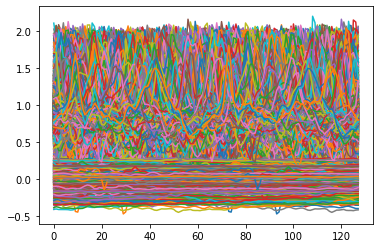

In [19]:
plt.plot(X_train.T)
plt.show()

In [20]:
# K-means time series: metric = "euclidean"
k_m = TimeSeriesKMeans(n_clusters=6, metric="euclidean", max_iter=5, random_state=0)
k_m.fit(X_train)

TimeSeriesKMeans(max_iter=5, n_clusters=6, random_state=0)

In [21]:
k_m.cluster_centers_.shape

(6, 128, 1)

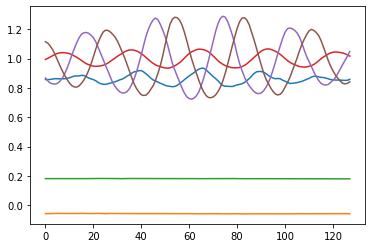

In [22]:
plt.plot(np.squeeze(k_m.cluster_centers_).T)
plt.show()

In [23]:
k_m.labels_

array([3, 3, 3, ..., 4, 4, 4], dtype=int64)

In [24]:
k_m.inertia_

4.238806111018568

In [25]:
# K-means time series: metric = "dtw"
k_m = TimeSeriesKMeans(n_clusters=6, metric="dtw", max_iter=5, random_state=0)
k_m.fit(X_train)

TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=6, random_state=0)

In [26]:
k_m.cluster_centers_.shape

(6, 128, 1)

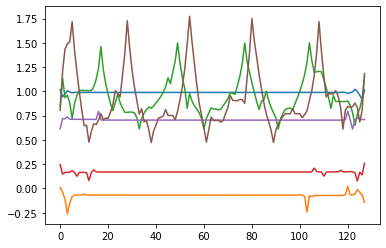

In [27]:
plt.plot(np.squeeze(k_m.cluster_centers_).T)
plt.show()

In [28]:
k_m.labels_

array([0, 0, 0, ..., 2, 2, 2], dtype=int64)

In [29]:
k_m.inertia_

0.8933206089106583

#### Feature-based clustering

In [30]:
from sklearn.cluster import KMeans

In [31]:
kmeans = KMeans(n_clusters=6, max_iter=5, random_state=0)
kmeans.fit(X_train)

KMeans(max_iter=5, n_clusters=6, random_state=0)

In [32]:
kmeans.inertia_

30008.596712587958

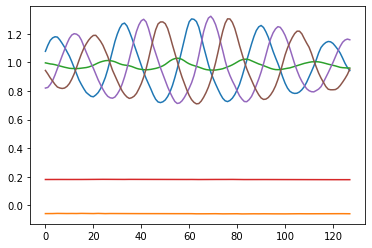

In [56]:
for c in range(6):
    plt.plot(np.mean(X_train[np.where(kmeans.labels_ == c)[0]], axis=0))
plt.show()

#### Approximated clustering

In [34]:
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation
from tslearn.piecewise import OneD_SymbolicAggregateApproximation

In [35]:
# K-means (metric="euclidean") + PAA
n_paa_segments = 10
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
X_paa = paa.fit_transform(X_train)

C:\Users\Cosimo\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 7352 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


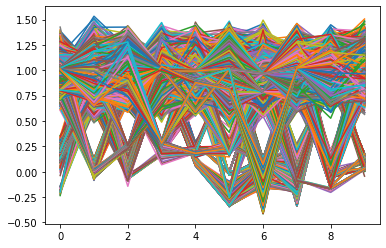

In [36]:
plt.plot(X_paa.reshape(X_paa.shape[1], X_paa.shape[0]))
plt.show()

In [37]:
km_paa = TimeSeriesKMeans(n_clusters=6, metric="euclidean", max_iter=5, random_state=0)
km_paa.fit(X_paa)

TimeSeriesKMeans(max_iter=5, n_clusters=6, random_state=0)

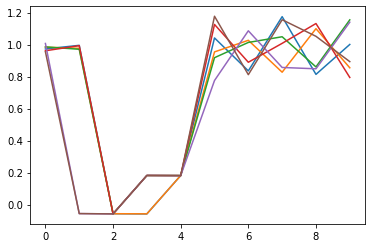

In [38]:
plt.plot(km_paa.cluster_centers_.reshape(X_paa.shape[1], 6))
plt.show()

In [39]:
km_paa.labels_

array([0, 0, 0, ..., 5, 5, 0], dtype=int64)

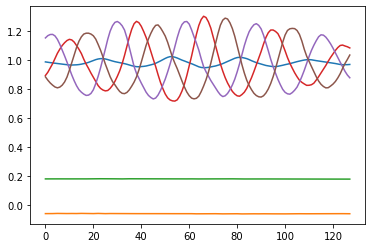

In [41]:
for i in range(6):
    plt.plot(np.mean(X_train[np.where(km_paa.labels_ == i)[0]], axis=0))
plt.show()

In [79]:
km_paa.cluster_centers_.shape

(6, 10, 1)

In [42]:
# K-means (metric="euclidean") + SAA
n_sax_symbols = 8
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)
X_sax = sax.fit_transform(X_train)

C:\Users\Cosimo\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 7352 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


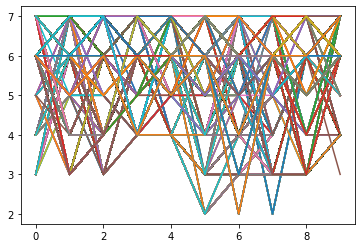

In [43]:
plt.plot(X_sax.reshape(X_sax.shape[1], X_sax.shape[0]))
plt.show()

In [44]:
km_sax = TimeSeriesKMeans(n_clusters=6, metric="euclidean", max_iter=5, random_state=0)
km_sax.fit(X_sax)

TimeSeriesKMeans(max_iter=5, n_clusters=6, random_state=0)

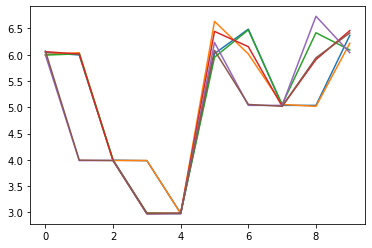

In [45]:
plt.plot(km_sax.cluster_centers_.reshape(X_sax.shape[1], 6))
plt.show()

In [46]:
km_sax.labels_

array([0, 0, 0, ..., 3, 3, 0], dtype=int64)

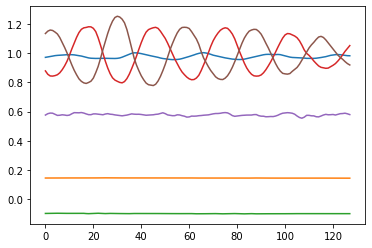

In [47]:
for i in range(6):
    plt.plot(np.mean(X_train[np.where(km_sax.labels_ == i)[0]], axis=0))
plt.show()

In [48]:
# K-means (metric="euclidean") + 1d-sax
n_sax_symbols_avg = 8
n_sax_symbols_slope = 4
one_d_sax = OneD_SymbolicAggregateApproximation(
    n_segments=n_paa_segments,
    alphabet_size_avg=n_sax_symbols_avg,
    alphabet_size_slope=n_sax_symbols_slope)
X_sax1d = one_d_sax.fit_transform(X_train)

C:\Users\Cosimo\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 7352 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [49]:
plt.plot(X_sax1d.reshape(X_sax1d.shape[1], X_sax1d.shape[0]))
plt.show()

ValueError: cannot reshape array of size 147040 into shape (10,7352)

In [57]:
km_sax1d = TimeSeriesKMeans(n_clusters=6, metric="euclidean", max_iter=5, random_state=0)
km_sax1d.fit(X_sax1d)

TimeSeriesKMeans(max_iter=5, n_clusters=6, random_state=0)

In [58]:
plt.plot(km_sax1d.cluster_centers_.reshape(X_sax1d.shape[1], 6))
plt.show()

ValueError: cannot reshape array of size 120 into shape (10,6)

In [59]:
km_sax1d.labels_

array([5, 0, 5, ..., 4, 4, 4], dtype=int64)

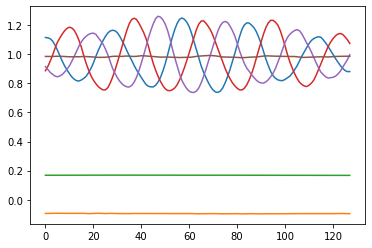

In [60]:
for i in range(6):
    plt.plot(np.mean(X_train[np.where(km_sax1d.labels_ == i)[0]], axis=0))
plt.show()

# 4. Analyze the dataset for finding motifs and/or anomalies. Visualize and discuss them and their relationship with other features.

Try to run the motif and anomalies to the clusters found in the previuos point

#### Matrix Profile

In [50]:
from matrixprofile import *

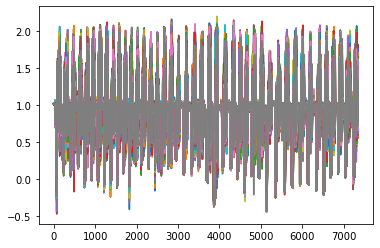

In [51]:
plt.plot(X_train)
plt.show()

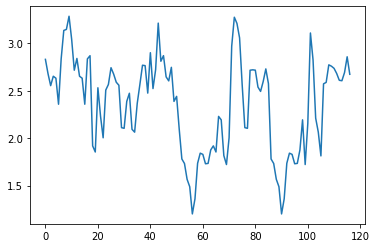

In [87]:
w = 12
mp, mpi = matrixProfile.stomp(X_train[0], w)

plt.plot(mp)
plt.show()

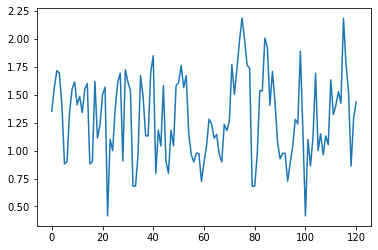

In [88]:
w = 8
mp, mpi = matrixProfile.stomp(X_train[0], w)

plt.plot(mp)
plt.show()

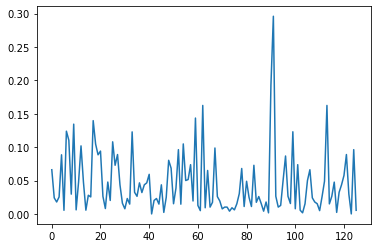

In [90]:
w = 3
mp, mpi = matrixProfile.stomp(X_train[0], w)

plt.plot(mp)
plt.show()

#### Motif discovery

In [92]:
mo, mod  = motifs.motifs(X_train[0], (mp, mpi), max_motifs=5)

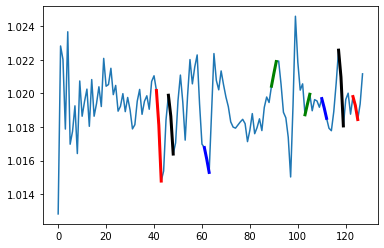

In [94]:
plt.plot(X_train[0])
colors = ['r', 'g', 'k', 'b', 'y'][:len(mo)]
for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = X_train[0][i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.show()

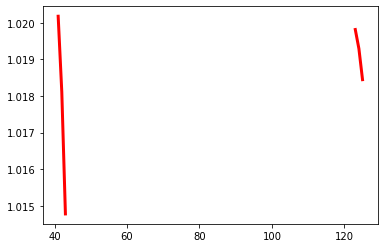

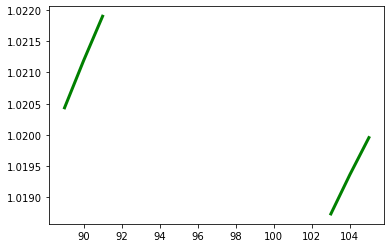

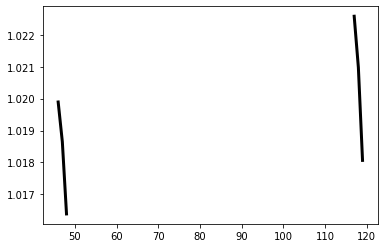

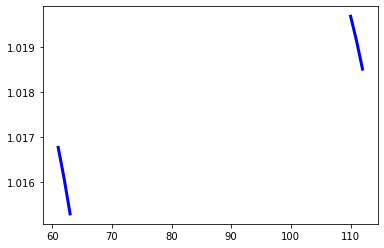

In [95]:
for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = X_train[0][i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)
    plt.show()

#### Anomaly discovery

In [96]:
from matrixprofile.discords import discords

In [97]:
anoms = discords(mp, ex_zone=3, k=5)

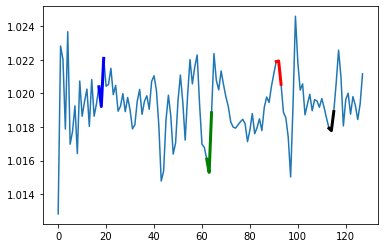

In [98]:
plt.plot(X_train[0])
colors = ['r', 'g', 'k', 'b', 'y'][:len(mo)]
for a, c in zip(anoms, colors):
    a_shape = X_train[0][a:a+w]
    plt.plot(range(a, a+w), a_shape, color=c, lw=3)

plt.show()

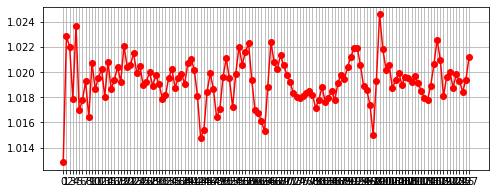

In [99]:
plt.figure(figsize=(8, 3))
x = X_train[0]
plt.plot(range(len(x)), x, marker='o', color='r')
plt.xticks(range(len(x)))
plt.grid()
plt.show()

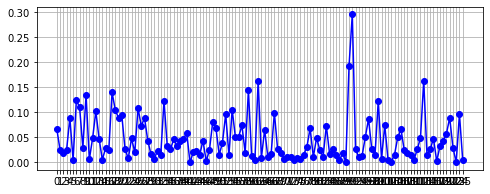

In [100]:
plt.figure(figsize=(8, 3))
plt.plot(mp, marker='o', color='b')
plt.xticks(range(len(mp)))
plt.grid()
plt.show()

#### Matrix Profile w/ clustering

In [50]:
from matrixprofile import *

In [101]:
k_m.cluster_centers_.shape

(6, 128, 1)

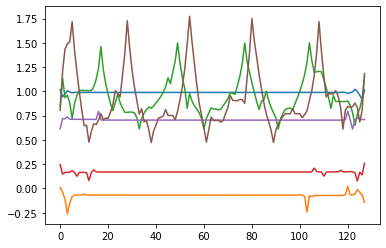

In [102]:
plt.plot(np.squeeze(k_m.cluster_centers_).T)
plt.show()

In [117]:
ts_clustering = k_m.cluster_centers_
ts_clustering.shape


(6, 128, 1)

In [118]:
w = 12
mp, mpi = matrixProfile.stomp(ts_clustering, w)

plt.plot(mp)
plt.show()

ValueError: negative dimensions are not allowed

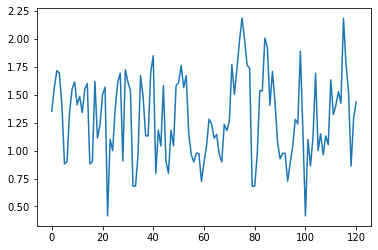

In [88]:
w = 8
mp, mpi = matrixProfile.stomp(X_train[0], w)

plt.plot(mp)
plt.show()

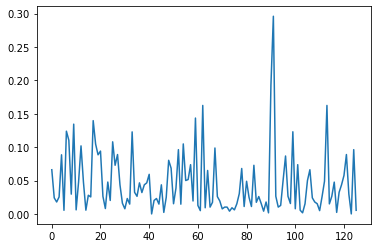

In [90]:
w = 3
mp, mpi = matrixProfile.stomp(X_train[0], w)

plt.plot(mp)
plt.show()

#### Motif discovery

In [92]:
mo, mod  = motifs.motifs(X_train[0], (mp, mpi), max_motifs=5)

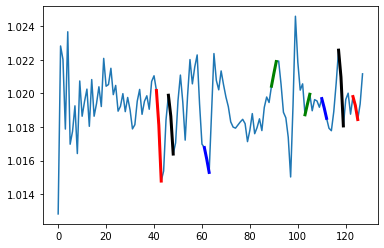

In [94]:
plt.plot(X_train[0])
colors = ['r', 'g', 'k', 'b', 'y'][:len(mo)]
for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = X_train[0][i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.show()

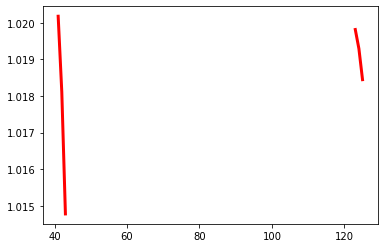

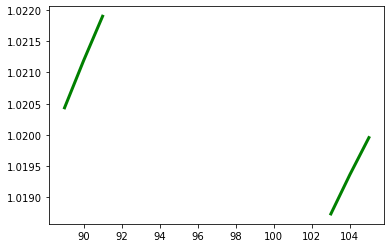

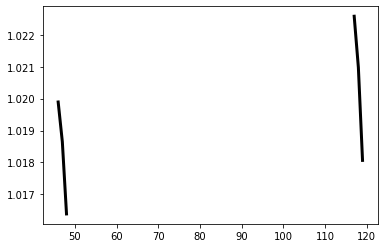

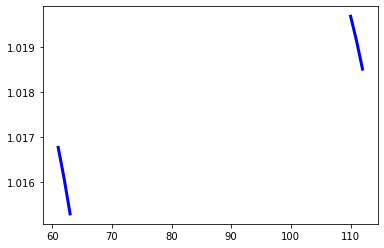

In [95]:
for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = X_train[0][i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)
    plt.show()

#### Anomaly discovery

In [96]:
from matrixprofile.discords import discords

In [97]:
anoms = discords(mp, ex_zone=3, k=5)

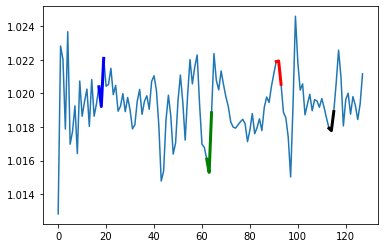

In [98]:
plt.plot(X_train[0])
colors = ['r', 'g', 'k', 'b', 'y'][:len(mo)]
for a, c in zip(anoms, colors):
    a_shape = X_train[0][a:a+w]
    plt.plot(range(a, a+w), a_shape, color=c, lw=3)

plt.show()

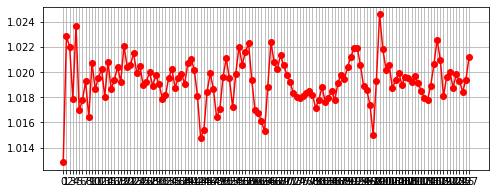

In [99]:
plt.figure(figsize=(8, 3))
x = X_train[0]
plt.plot(range(len(x)), x, marker='o', color='r')
plt.xticks(range(len(x)))
plt.grid()
plt.show()

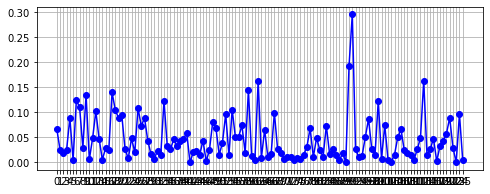

In [100]:
plt.figure(figsize=(8, 3))
plt.plot(mp, marker='o', color='b')
plt.xticks(range(len(mp)))
plt.grid()
plt.show()

# 5. Solve the classification task on the time series dataset(s) and evaluate each result. In particular, you should use shapelet-based classifiers and structural-based classifiers. Analyze the shapelets retrieved and discuss if there are any similarities/differences with motifs and/or shapelets.

Try to use motif found in the previous point as shapelet

#### Data normalization

In [131]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [119]:
from tslearn.preprocessing import TimeSeriesScalerMinMax

In [120]:
scaler = TimeSeriesScalerMinMax()
X_train = scaler.fit_transform(X_train).reshape(X_train.shape[0], X_train.shape[1])

In [121]:
X_train.shape

(7352, 128)

#### Shapelet classifiers (Learning base approach)

In [123]:
from tensorflow.keras.optimizers import Adagrad
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict

In [125]:
n_ts, ts_sz = X_train.shape
n_classes = 6

# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 7352
ts_sz 128
n_classes 6
shapelet_sizes {12: 6}


In [126]:
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        weight_regularizer=.01,
                        max_iter=200,
                        verbose=1)

C:\Users\Cosimo\anaconda3\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


In [127]:
shp_clf.fit(X_train, y_train)

C:\Users\Cosimo\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/200
29/29 [==============================] - 1s 10ms/step - loss: 1.8698 - categorical_accuracy: 0.1440 - categorical_crossentropy: 1.7939
Epoch 2/200
29/29 [==============================] - 0s 10ms/step - loss: 1.8682 - categorical_accuracy: 0.1763 - categorical_crossentropy: 1.7932
Epoch 3/200
29/29 [==============================] - 0s 11ms/step - loss: 1.8667 - categorical_accuracy: 0.1863 - categorical_crossentropy: 1.7925
Epoch 4/200
29/29 [==============================] - 0s 10ms/step - loss: 1.8652 - categorical_accuracy: 0.1941 - categorical_crossentropy: 1.7919
Epoch 5/200
29/29 [==============================] - 0s 9ms/step - loss: 1.8638 - categorical_accuracy: 0.2027 - categorical_crossentropy: 1.7913
Epoch 6/200
29/29 [==============================] - 0s 10ms/step - loss: 1.8624 - categorical_accuracy: 0.2115 - categorical_crossentropy: 1.7908
Epoch 7/200
29/29 [==============================] - 0s 10ms/step - loss: 1.8611 - categorical_accuracy: 0.2252 - categ

29/29 [==============================] - 0s 9ms/step - loss: 1.8041 - categorical_accuracy: 0.2099 - categorical_crossentropy: 1.7829
Epoch 112/200
29/29 [==============================] - 0s 9ms/step - loss: 1.8038 - categorical_accuracy: 0.2110 - categorical_crossentropy: 1.7829
Epoch 113/200
29/29 [==============================] - 0s 9ms/step - loss: 1.8036 - categorical_accuracy: 0.2088 - categorical_crossentropy: 1.7829
Epoch 114/200
29/29 [==============================] - 0s 9ms/step - loss: 1.8033 - categorical_accuracy: 0.2095 - categorical_crossentropy: 1.7829
Epoch 115/200
29/29 [==============================] - 0s 9ms/step - loss: 1.8031 - categorical_accuracy: 0.2091 - categorical_crossentropy: 1.7829
Epoch 116/200
29/29 [==============================] - 0s 10ms/step - loss: 1.8028 - categorical_accuracy: 0.2092 - categorical_crossentropy: 1.7828
Epoch 117/200
29/29 [==============================] - 0s 9ms/step - loss: 1.8026 - categorical_accuracy: 0.2078 - categorica

LearningShapelets(max_iter=200, n_shapelets_per_size={12: 6}, verbose=1,
                  weight_regularizer=0.01)

In [129]:
y_pred = shp_clf.predict(X_test)

12/12 [==============================] - 0s 7ms/step


In [132]:
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.19443501866304716
F1-score [0.         0.         0.         0.         0.30948226 0.14186851]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       496
           2       0.00      0.00      0.00       471
           3       0.00      0.00      0.00       420
           4       0.00      0.00      0.00       491
           5       0.18      1.00      0.31       532
           6       1.00      0.08      0.14       537

    accuracy                           0.19      2947
   macro avg       0.20      0.18      0.08      2947
weighted avg       0.22      0.19      0.08      2947



C:\Users\Cosimo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Cosimo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Cosimo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Shapelet distance-based classifier

In [133]:
X_train2 = shp_clf.transform(X_train)

29/29 [==============================] - 0s 9ms/step


In [134]:
X_test2 = shp_clf.transform(X_test)

12/12 [==============================] - 0s 7ms/step


In [135]:
from sklearn.neighbors import KNeighborsClassifier

In [136]:
clf = KNeighborsClassifier(n_neighbors=20, weights='uniform')
clf.fit(X_train2, y_train)

C:\Users\Cosimo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=20)

In [137]:
y_pred = clf.predict(X_test2)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.18052256532066507
F1-score [0.         0.         0.         0.         0.30751445 0.        ]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       496
           2       0.00      0.00      0.00       471
           3       0.00      0.00      0.00       420
           4       0.00      0.00      0.00       491
           5       0.18      1.00      0.31       532
           6       0.00      0.00      0.00       537

    accuracy                           0.18      2947
   macro avg       0.03      0.17      0.05      2947
weighted avg       0.03      0.18      0.06      2947



C:\Users\Cosimo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Cosimo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Cosimo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [138]:
from sklearn.tree import DecisionTreeClassifier

In [139]:
clf = DecisionTreeClassifier(max_depth=8, random_state=42)
clf.fit(X_train2, y_train)

y_pred = clf.predict(X_test2)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.25653206650831356
F1-score [0.         0.         0.         0.         0.33745639 0.5848564 ]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       496
           2       0.00      0.00      0.00       471
           3       0.00      0.00      0.00       420
           4       0.00      0.00      0.00       491
           5       0.20      1.00      0.34       532
           6       0.98      0.42      0.58       537

    accuracy                           0.26      2947
   macro avg       0.20      0.24      0.15      2947
weighted avg       0.21      0.26      0.17      2947



C:\Users\Cosimo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Cosimo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Cosimo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
